# Test4 with Benchmarking

In [1]:
from itertools import product
import os
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, accuracy_score
import statsmodels.api as sm
from tqdm.notebook import tqdm

from doe_modules.design import DOE, FullFactorial, CLOO, PlackettBurman, d_criterion, DOCLOO
from doe_modules.plot import bio_multicomp
from doe_modules.preferences import kwarg_savefig, outputdir
from doe_modules.simulation import Test4, MLR, AbstractSimulator, TheoreticalEffects

In [2]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir
    simulator: AbstractSimulator = Test4
    run_names: list = None
    suffix: str = "_test4"
    output_filepath: str = f"{out}/esm{suffix}.feather"

conf = Config()

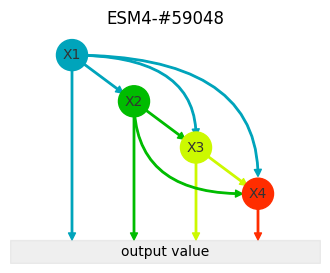

In [3]:
fig, ax = plt.subplots(figsize=(4, 3))

conf.simulator(edge_assignment=[1] * 10).plot(ax=ax)
ax.set_title(conf.simulator(edge_assignment=[1] * 10, model_id=3 ** 10 - 1).name);

In [4]:
if not os.path.exists(conf.output_filepath):

    edges = np.array(list(map(list, product([-1, 0, 1], repeat=10))))

    conditions = dict(
        pb=[conf.simulator(v, model_id=i) for i, v in enumerate(edges)],
        cloo=[conf.simulator(v, model_id=i) for i, v in enumerate(edges)],
    )

    designs = dict(
        pb=PlackettBurman,
        cloo=CLOO,
    )

In [5]:
if not os.path.exists(conf.output_filepath):
    for k, models in tqdm(conditions.items(), total=len(designs)):
        [
            m.simulate(
                design=designs[k], n_rep=3
            ) for (i, m) in tqdm(enumerate(models), total=len(edges))
        ]

In [6]:
if not os.path.exists(conf.output_filepath):

    theoretical = [
        TheoreticalEffects(
            simulation=conf.simulator(v, model_id=i), random_state=0
        ) for i, v in tqdm(enumerate(edges), total=len(edges))
    ]

    ground_truth = [
        theoretical[i].summary(dtype=int) for i in tqdm(range(len(edges)))
    ]

In [7]:
if not os.path.exists(conf.output_filepath):

    import warnings

    warnings.simplefilter('ignore')

    pb_k, cloo_k = [], []
    pb_dd, cloo_dd = [], []

    def kappa(res, gt):
        if gt.unique().size == 1:
            f = lambda res, gt: accuracy_score(res, gt)
        else:
            f = lambda res, gt: cohen_kappa_score(res, gt, weights="linear")
        return np.nan if res.isna().all() else f(res, gt)

    # kappa = lambda res, gt: np.nan if res.isna().all() else cohen_kappa_score(res, gt, weights="linear")

    for (pb, cloo, gt) in tqdm(zip(conditions["pb"], conditions["cloo"], ground_truth), total=len(edges)):
        pb_res = MLR(pb).summary(anova=True, dtype=int, fill_nan=True)
        cloo_res = MLR(cloo).summary(anova=True, dtype=int, fill_nan=True)
        pb_k += [kappa(pb_res, gt)]
        cloo_k += [kappa(cloo_res, gt)]

In [8]:
def voronoi(c_p):
    c, p = c_p
    if c < .6 and p < .6:
        ret = 0
    elif c > p:
        ret = 1
    elif c < p:
        ret = 2
    else:
        ret = 3
    return ret

def voronoi_label(c_p):
    return ["neither", "C+LOO", "PB", "both"][voronoi(c_p)]

In [9]:
if os.path.exists(conf.output_filepath):
    dat = pd.read_feather(conf.output_filepath)

else:
    dat = pd.DataFrame({
        "cloo": cloo_k,
        "pb": pb_k,
        "v": list(map(voronoi, [[c, p] for c, p in zip(cloo_k, pb_k)])),
        "": list(map(voronoi_label, [[c, p] for c, p in zip(cloo_k, pb_k)])),
    })

    dat.to_feather(conf.output_filepath)

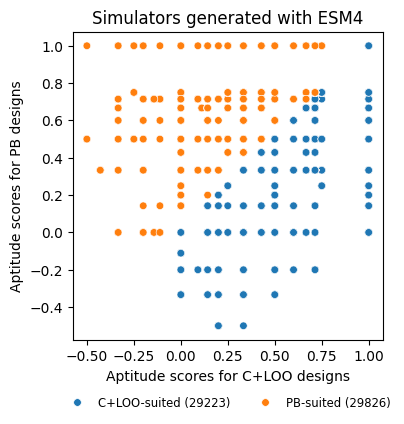

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))

# counts = dat.loc[:, ''].value_counts()
counts = (dat.pb > dat.cloo).astype(int).value_counts()

dat2 = pd.DataFrame({
    "cloo": dat.cloo,
    "pb": dat.pb,
    "v": [["C+LOO-suited", "PB-suited"][v] for v in (dat.pb > dat.cloo).astype(int)],
    "": [
        ["C+LOO-suited", "PB-suited"][v] + f" ({counts[v]})" for v in (dat.pb > dat.cloo).astype(int)
    ]

})

sns.scatterplot(
    dat2.sort_values("v"),
    x="cloo", 
    y="pb", 
    hue="",
    # palette=[".7", "C0", "C1", "C4"],
    palette=["C0", "C1"],
    s=30, rasterized=True
)

ax.set(
    title="Simulators generated with ESM4",
    xlabel="Aptitude scores for C+LOO designs", 
    ylabel="Aptitude scores for PB designs"
)

ax.legend(loc="upper center", fontsize="small", bbox_to_anchor=(.5, -.15), ncol=2, frameon=False)

if conf.savefig:
    fig.savefig(f"{conf.out}/kappa_scatter{conf.suffix}.pdf", **kwarg_savefig)

In [11]:
dat

,cloo,pb,v,
0,0.000000,0.000000,0,neither
1,0.000000,0.000000,0,neither
2,0.000000,0.000000,0,neither
3,0.000000,0.000000,0,neither
4,0.000000,0.000000,0,neither
...,...,...,...,...
59044,0.750000,0.750000,3,both
59045,1.000000,0.750000,1,C+LOO
59046,0.333333,-0.333333,0,neither
59047,0.750000,0.750000,3,both
